In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tex_fonts = {
    #source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    #"axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble': r"\usepackage{amsmath}"
}

import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Display the GeoDataFrame to ensure it's correct
print(gdf.head())

                    LSOA21NM   centroid_x   centroid_y  c_percent asian  \
0        City of London 001A  532151.1942  181615.2014         0.107191   
1        City of London 001B  532443.6860  181645.7249         0.130592   
2        City of London 001C  532207.0148  182030.1296         0.094913   
3        City of London 001E  533618.3485  181157.3543         0.321526   
4  Barking and Dagenham 016A  544934.3697  184297.5465         0.479675   

   c_percent black  c_percent mixed  c_percent white  c_percent sikh  \
0         0.007463         0.037992         0.801221        0.000000   
1         0.007937         0.043290         0.782107        0.000000   
2         0.034739         0.062655         0.741315        0.001860   
3         0.108084         0.071753         0.385104        0.000000   
4         0.108401         0.037940         0.327913        0.036295   

   c_percent hindu  c_percent christian  ...  o_opioids_quantity_per_capita  \
0         0.026441             0.3457

C:\Users\0\AppData\Local\Temp\ipykernel_5584\612648604.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


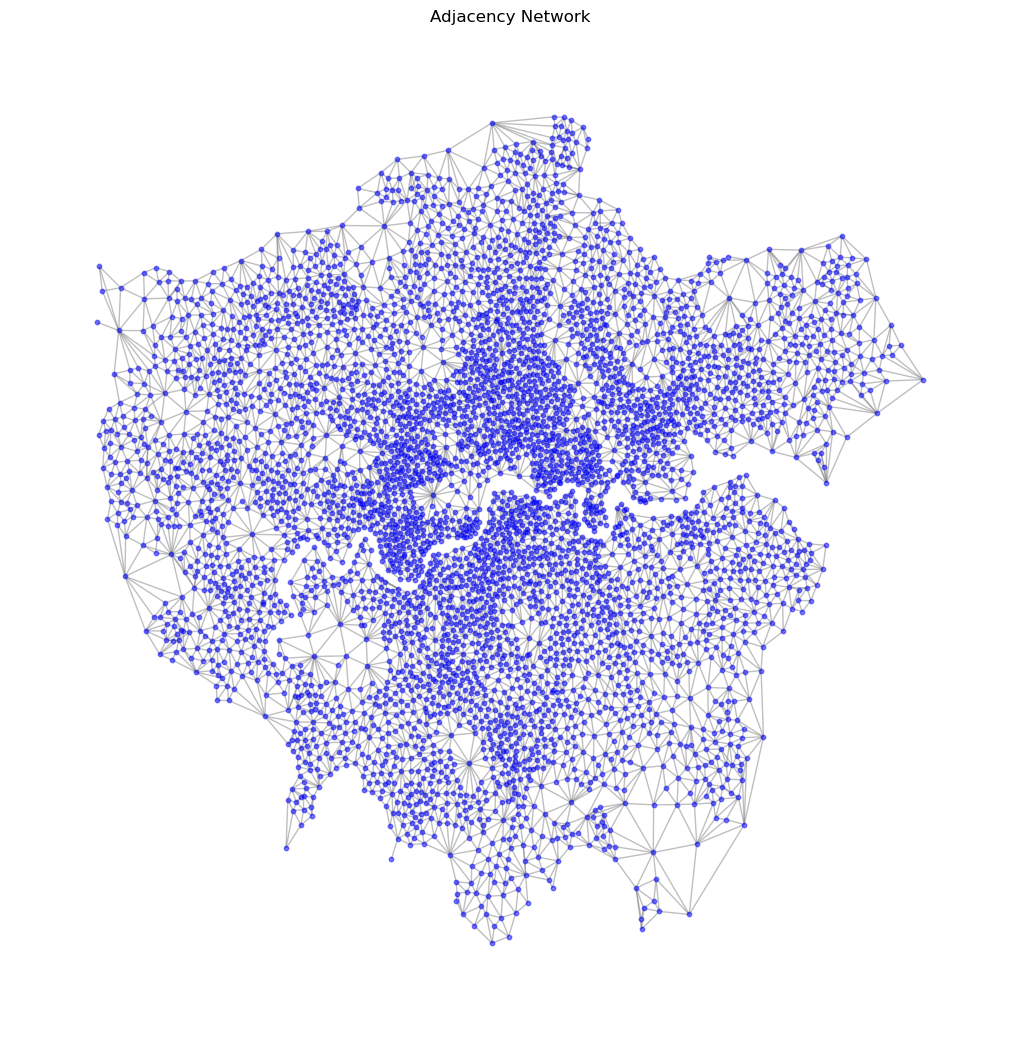

In [2]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

In [3]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    # 'e_NO2',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    # 'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    # 'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   45.952547
1                       c_percent Aged 15 to 19 years   17.553844
2                       c_percent Aged 20 to 24 years   34.235183
3                       c_percent Aged 25 to 29 years   36.637117
4                       c_percent Aged 30 to 34 years   57.487355
5                       c_percent Aged 35 to 39 years   72.134061
6                       c_percent Aged 40 to 44 years   72.721801
7                       c_percent Aged 65 to 69 years   34.952682
8                       c_percent Aged 70 to 74 years   33.932029
9                       c_percent Aged 75 to 79 years   26.678872
10                      c_percent Aged 80 to 84 years   19.878863
11                   c_percent Aged 85 years and over   10.233184
12                                    c_percent mixed   21.422281
13                                    c_percent white

In [4]:
def plot_variable_v2(gdf, variable, variable_name):

    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        # 'color':'#808080',
        # 'edgecolor': 'black',
        # 'hatch': '///',  # this is optional, if you'd like a hatch pattern for missing data
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame
    ax = gdf.plot(column=variable, legend=True, figsize=(15, 10), cmap=colormap, missing_kwds=missing_data_color)

    # Remove the axes
    plt.axis('off')

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=33)

    # Title
    plt.title(variable_name, fontsize=44)

    return plt

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 假设你已经有一个数据对象 data
# data = ...

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 随机搜索超参数
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

KeyboardInterrupt: 

In [5]:
best_params = {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}

In [5]:
best_params = {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}

Shape of embeddings: (4994, 32)
PCA1 Top Contributors:
7     0.351941
11    0.293557
12    0.242495
3     0.241820
2     0.192453
22    0.135659
14    0.105624
28    0.084379
21    0.081191
29    0.062971
Name: PCA1, dtype: float32

PCA2 Top Contributors:
1     0.329506
23    0.172351
7     0.122271
0     0.113049
24    0.107758
17    0.087978
27    0.084714
2     0.076637
3     0.072696
25    0.059232
Name: PCA2, dtype: float32


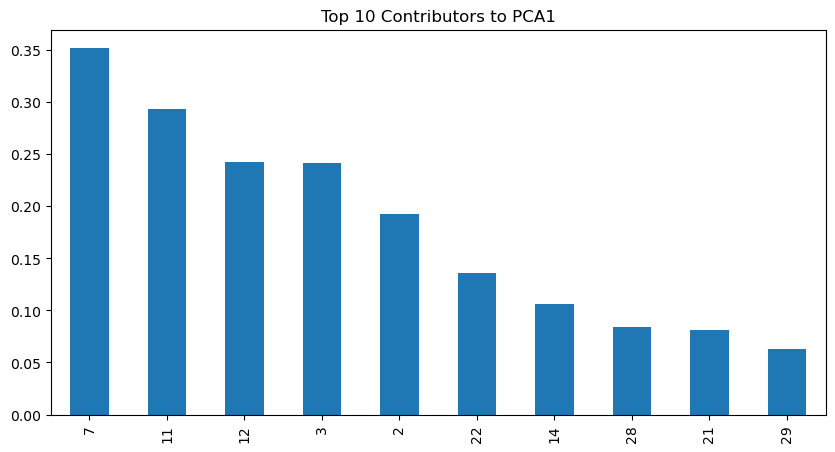

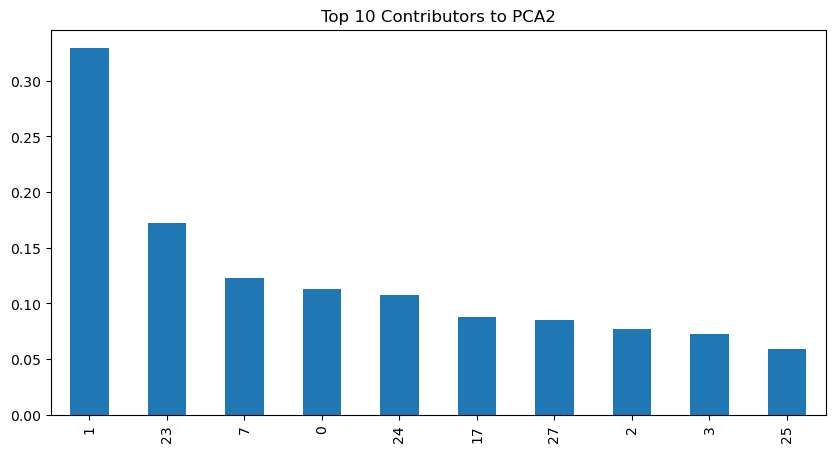

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 设置随机种子以确保可重复性
torch.manual_seed(0)
np.random.seed(0)

# 假设 GNN 模型和数据已经定义
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout
        self.hidden2 = hidden2

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        return x

# 假设你已经有一个数据对象 data 和最佳超参数 best_params

# 训练好的模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# 提取嵌入
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).detach().numpy()

# 确保嵌入已定义
print(f"Shape of embeddings: {embeddings.shape}")

# 计算加载矩阵
pca = PCA(n_components=2, random_state=0)
pca_result = pca.fit_transform(embeddings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# 创建加载矩阵DataFrame
loading_matrix = pd.DataFrame(loadings, columns=['PCA1', 'PCA2'])

# 打印每个主成分的前几个变量及其贡献
print("PCA1 Top Contributors:")
print(loading_matrix['PCA1'].sort_values(ascending=False).head(10))

print("\nPCA2 Top Contributors:")
print(loading_matrix['PCA2'].sort_values(ascending=False).head(10))

# 可视化每个主成分的前几个变量及其贡献
plt.figure(figsize=(10, 5))
loading_matrix['PCA1'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Contributors to PCA1')
plt.show()

plt.figure(figsize=(10, 5))
loading_matrix['PCA2'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Contributors to PCA2')
plt.show()


<module 'matplotlib.pyplot' from 'C:\\Users\\0\\anaconda3\\envs\\envGEOG0051\\Lib\\site-packages\\matplotlib\\pyplot.py'>

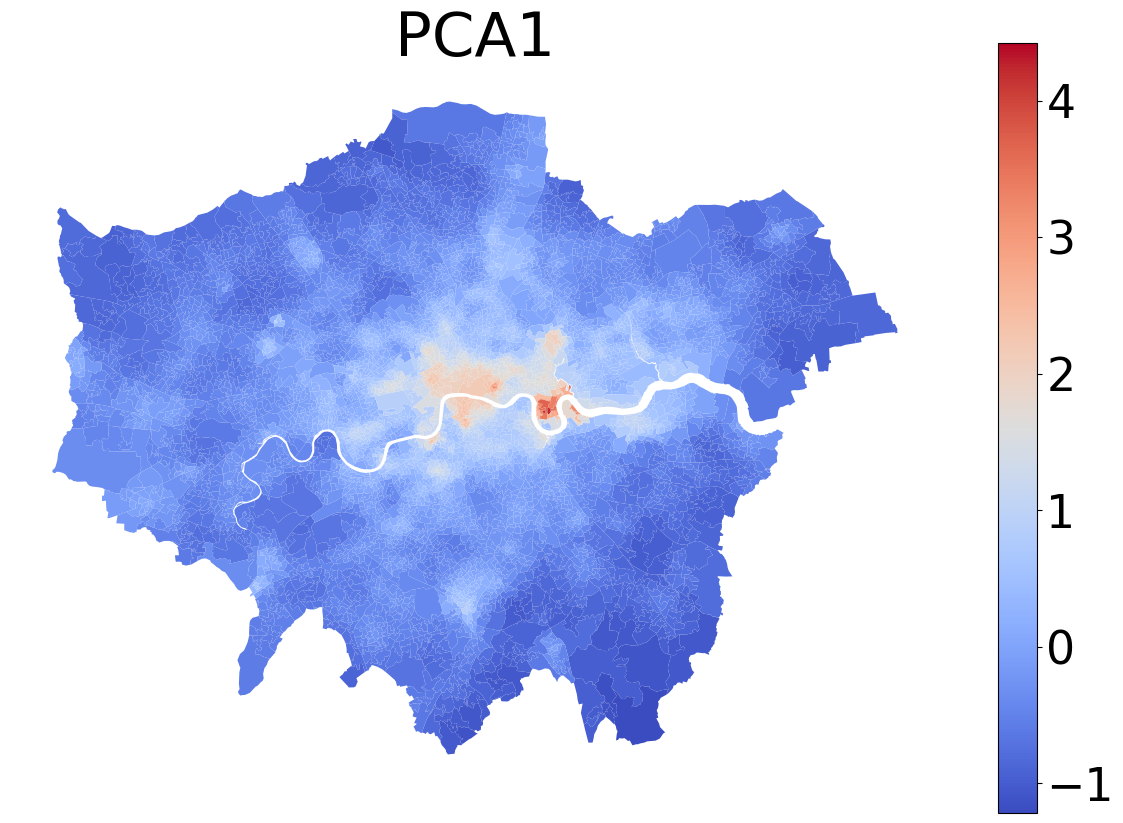

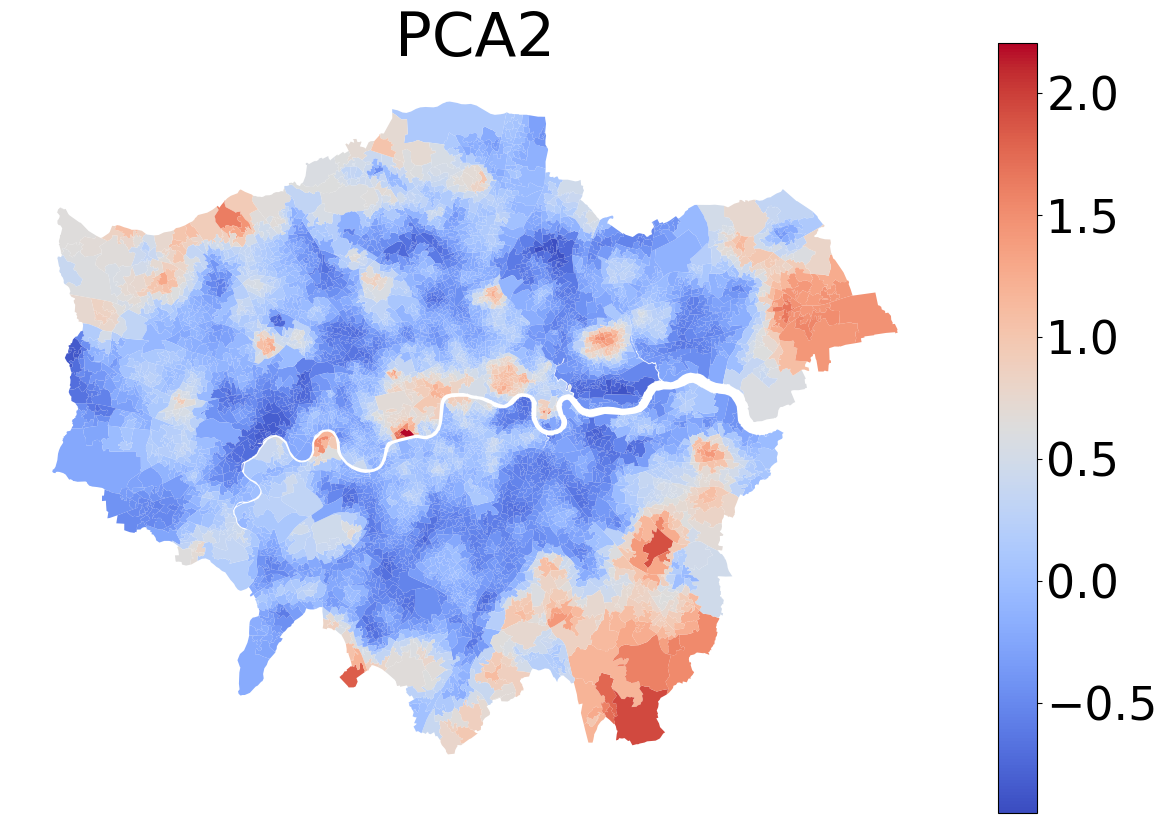

In [7]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf_plot = gpd.GeoDataFrame(df, geometry='geometry')

# 将PCA结果添加到GeoDataFrame中
gdf_plot['PCA1'] = pca_result[:, 0]
gdf_plot['PCA2'] = pca_result[:, 1]

# 可视化PCA1和PCA2
plot_variable_v2(gdf_plot, 'PCA1', 'PCA1')
plot_variable_v2(gdf_plot, 'PCA2', 'PCA2')

In [20]:
model

GATv2(
  (conv1): GATv2Conv(46, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

MSE: 13.0604
RMSE: 3.6139
MAE: 2.6330
R²: 0.8433


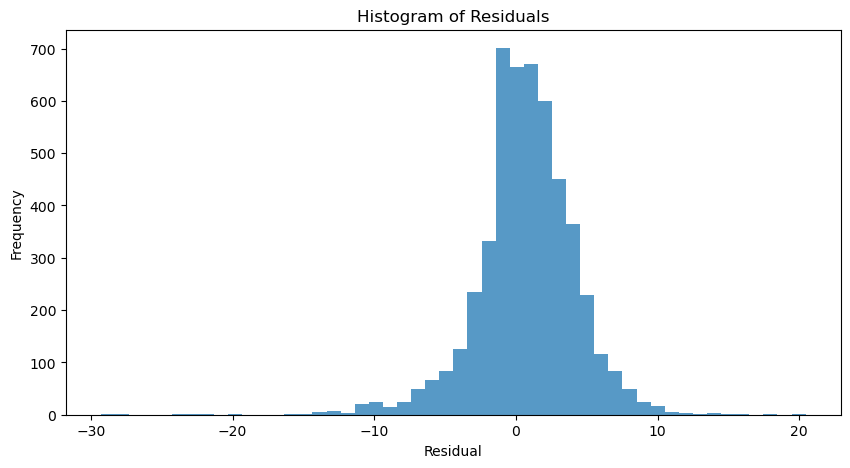

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm
# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()
# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [9]:
# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
# 将预测值添加到 GeoDataFrame 中
gdf['o_pre_anxiety'] = y_pred

# 检查结果
print(gdf[['o_anxiety_quantity_per_capita', 'o_pre_anxiety']].head())
# 计算残差并添加到 GeoDataFrame 中
gdf['o_residual_anxiety'] = gdf['o_anxiety_quantity_per_capita'] - gdf['o_pre_anxiety']

# 检查结果
print(gdf[['o_anxiety_quantity_per_capita', 'o_pre_anxiety', 'o_residual_anxiety']].head())


   o_anxiety_quantity_per_capita  o_pre_anxiety
0                       0.478279       2.218352
1                       0.757793       1.682280
2                       1.391262       2.754462
3                       1.842563       1.056757
4                      11.725343      10.629092
   o_anxiety_quantity_per_capita  o_pre_anxiety  o_residual_anxiety
0                       0.478279       2.218352           -1.740073
1                       0.757793       1.682280           -0.924487
2                       1.391262       2.754462           -1.363199
3                       1.842563       1.056757            0.785806
4                      11.725343      10.629092            1.096250


<module 'matplotlib.pyplot' from 'C:\\Users\\0\\anaconda3\\envs\\envGEOG0051\\Lib\\site-packages\\matplotlib\\pyplot.py'>

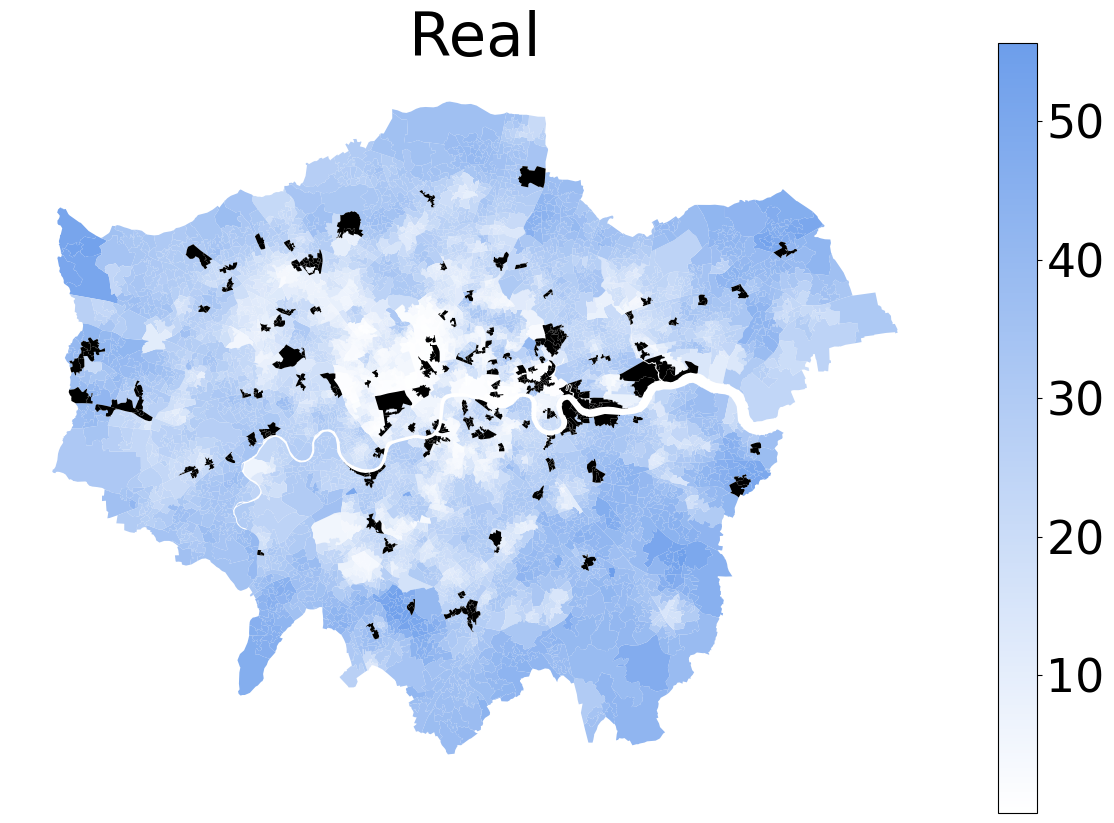

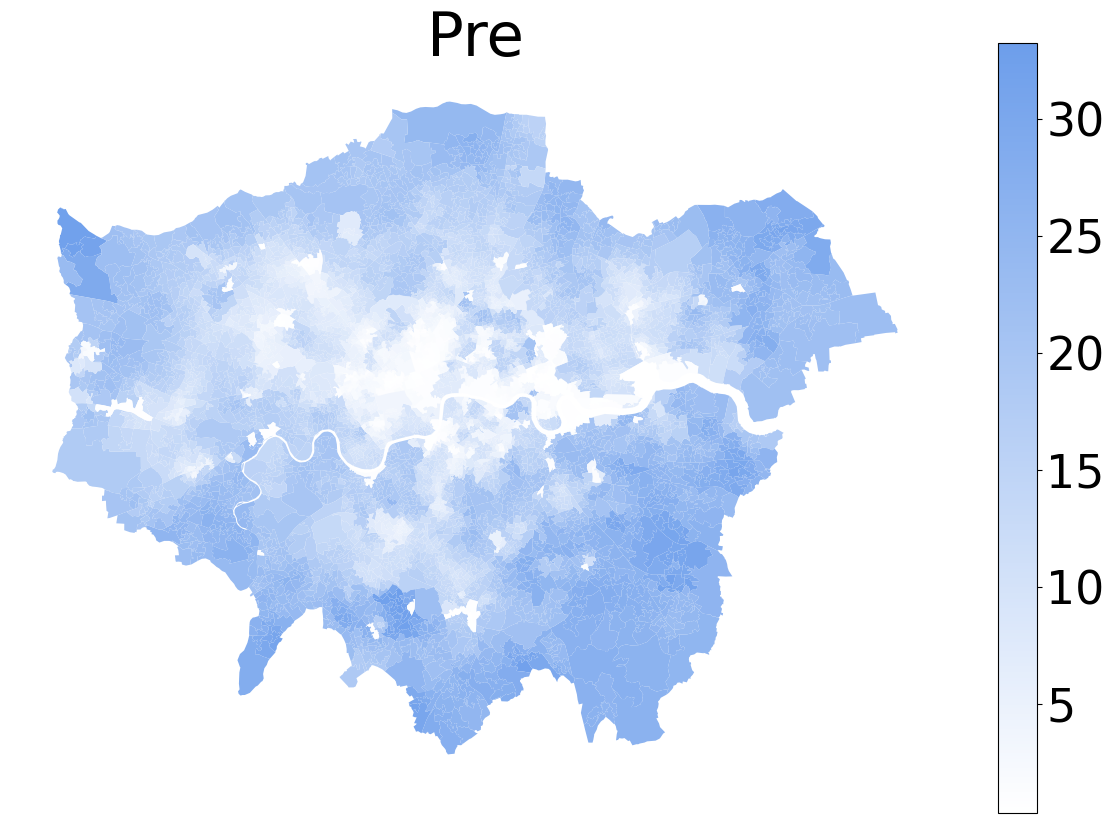

In [10]:
import matplotlib.colors as colors
variable = 'o_anxiety_quantity_per_capita'
variable_name = 'Real'
plot_variable_v2(gdf, variable, variable_name)
variable = 'o_pre_anxiety'
variable_name = 'Pre'
plot_variable_v2(gdf, variable, variable_name)

In [12]:
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
model.eval()

for explanation_type in ['phenomenon', 'model']:
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 1000
explanation = explainer(data.x, data.edge_index, index=node_idx)

In [13]:
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'
